<a href="https://colab.research.google.com/github/LorenzoKaufmann/crypto_forecast/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import

In [1]:
from datetime import datetime, timedelta
from textblob import TextBlob
import pandas as pd
import spacy
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os


In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("vader_lexicon")
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
from google.colab import drive
drive.mount('/drive')
folder_path = '/drive/My Drive/Colab Notebooks/Crypto Project/Data/reddit_posts'
folder_path_daily_update = '/drive/My Drive/Colab Notebooks/Crypto Project/Data/reddit_posts/Daily_Update'
test_case = False

Mounted at /drive


###read JSON File

In [4]:
def read_json_data(folder_path, get_function='all'):
  days_list = [f[17:-5] for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f))]
  print(f'List of Days: {days_list}')
  all_posts = pd.DataFrame(columns=['index', 'title', 'score', 'text', 'author', 'url',
                                    'num_comments', 'subreddit', 'fetch_method'])
  for day in days_list:
    filename = f'reddit_posts_{get_function}_{day}.json'
    posts_df = pd.read_json(os.path.join(folder_path, filename),  orient='index')
    posts_df['created_utc'] = pd.to_datetime(posts_df['created_utc'], unit='s')
    posts_df = posts_df.reset_index().set_index('created_utc')
    if all_posts.empty:
      all_posts = posts_df
    else:
      all_posts = pd.concat([all_posts, posts_df])
  all_posts = all_posts.drop_duplicates(subset='index', keep='first')
  return all_posts


all_reddit_posts = read_json_data(folder_path_daily_update, get_function='all')

List of Days: ['2024_11_22', '2024_11_23', '2024_11_25', '2024_11_26', '2024_11_27', '2024_11_29', '2024_12_03', '2024_12_04', '2024_12_11', '2024_12_16', '2025_07_20']


In [5]:
test_case = True
if test_case:
  print(all_reddit_posts.columns)
  print(all_reddit_posts.describe())
  print(all_reddit_posts.head())

Index(['index', 'title', 'score', 'author', 'url', 'text', 'num_comments',
       'subreddit', 'fetch_method'],
      dtype='object')
              score  num_comments
count   4997.000000   4997.000000
mean    1584.958175    318.075846
std     3814.252195    898.960994
min        0.000000      0.000000
25%        0.000000     12.000000
50%       20.000000     53.000000
75%      392.000000    223.000000
max    53906.000000  42698.000000
                       index  \
created_utc                    
2024-11-17 16:36:45  1gthhns   
2024-11-22 00:00:23  1gwuall   
2024-11-21 21:15:06  1gwqj7i   
2024-11-21 21:58:08  1gwrjg2   
2024-11-21 18:04:20  1gwlsx3   

                                                                 title  score  \
created_utc                                                                     
2024-11-17 16:36:45  It’s Scam Awareness Week at Kraken and we’re s...     94   
2024-11-22 00:00:23  Daily Crypto Discussion - November 22, 2024 (G...     52   
2024-11-21 

In [7]:
def text_analysis(row, colname):
    # print(text)
    text = row[colname]
    norm_score = row['norm_score']
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity
    return sentiment * norm_score

In [8]:
def text_analysis_VADER(row, colname, sia):
    # print(text)
    text = row[colname]
    norm_score = row['norm_score']
    sentiment = sia.polarity_scores(text)["compound"]  # Analyze sentiment
    return sentiment # * norm_score


In [6]:
if test_case:
  txt = all_reddit_posts['text'].iloc[0]
  print(txt)
  analysis = TextBlob(txt)
  sentiment = analysis.sentiment.polarity
  print(sentiment)

Hi Redditors!   
  
As the world of digital finance continues to evolve, it's essential to stay informed about the risks associated with fraudulent activities. It has been estimated that around $485.6 Billion was lost in Scams & Schemes in 2023 (source - NASDAQ 2024 Global Financial Crime Report). During Scam Awareness Week, we aim to educate users on how to protect themselves from scams and highlight the industry's efforts to create a safer ecosystem.

Follow our socials for more scam awareness tips and be sure to tune in this **Thursday November 21st** at 1pm ET (18:00 UTC) for a **special live stream** with Scam-baiter **Kitboga** and Kraken’s CISO **Nick Percoco**. Tune in on [Kit’s Twitch](https://www.twitch.tv/kitboga)! 

(ICYMI the last time Nick P & Kitboga got together, they got revenge on an extortion scammer. [https://www.youtube.com/watch?v=RfgqMVheROA](https://www.youtube.com/watch?v=RfgqMVheROA)) 

There’s a lot of advice out there, here are some practical tips...  


htt

In [ ]:
print(all_reddit_posts.columns)

Index(['index', 'title', 'score', 'author', 'url', 'text', 'num_comments',
       'subreddit', 'fetch_method'],
      dtype='object')


In [9]:
max_score, min_score = (all_reddit_posts['score'].max(), all_reddit_posts['score'].min())
sia = SentimentIntensityAnalyzer()

all_reddit_posts['norm_score'] = all_reddit_posts['score'] / max_score
all_reddit_posts['sent_analysis_text'] = all_reddit_posts.apply(text_analysis, args=('text',), axis=1)
all_reddit_posts['sent_analysis_title'] = all_reddit_posts.apply(text_analysis, args=('title',), axis=1)
all_reddit_posts['sent_analysis_title_VADER'] = all_reddit_posts.apply(text_analysis_VADER, args=('title', sia), axis=1)

In [10]:
print(all_reddit_posts['sent_analysis_text'].describe())
print(all_reddit_posts['sent_analysis_title'].describe())
print(all_reddit_posts['sent_analysis_title_VADER'].describe())

print(all_reddit_posts['norm_score'].describe())

count    4997.000000
mean        0.001386
std         0.010502
min        -0.266667
25%         0.000000
50%         0.000000
75%         0.000002
max         0.269311
Name: sent_analysis_text, dtype: float64
count    4997.000000
mean        0.001452
std         0.017965
min        -0.298035
25%         0.000000
50%         0.000000
75%         0.000000
max         0.211386
Name: sent_analysis_title, dtype: float64
count    4997.000000
mean        0.018098
std         0.341810
min        -0.948100
25%         0.000000
50%         0.000000
75%         0.202300
max         0.938100
Name: sent_analysis_title_VADER, dtype: float64
count    4997.000000
mean        0.029402
std         0.070757
min         0.000000
25%         0.000000
50%         0.000371
75%         0.007272
max         1.000000
Name: norm_score, dtype: float64


Index(['created_utc', 'num_comments', 'fetch_method', 'index',
       'sent_analysis_title_VADER', 'month'],
      dtype='object')
          created_utc  num_comments        fetch_method    index  \
0 2025-07-16 15:02:33            61         top_new_hot  1m1exbt   
1 2025-07-19 15:01:11           222  rising_top_new_hot  1m3ycbk   
2 2025-07-19 16:04:47            41  rising_top_new_hot  1m3zv8i   
3 2025-07-19 12:23:20            62  rising_top_new_hot  1m3uxwl   
4 2025-07-19 20:50:10            40  rising_top_new_hot  1m46ow2   

   sent_analysis_title_VADER   month  
0                     0.5562  7 2025  
1                     0.0000  7 2025  
2                     0.0000  7 2025  
3                    -0.4019  7 2025  
4                     0.0258  7 2025  


/tmp/ipython-input-11-1940282360.py:42: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  axes[1].plot(daily_median.index, daily_median, color='orange', label='Median')


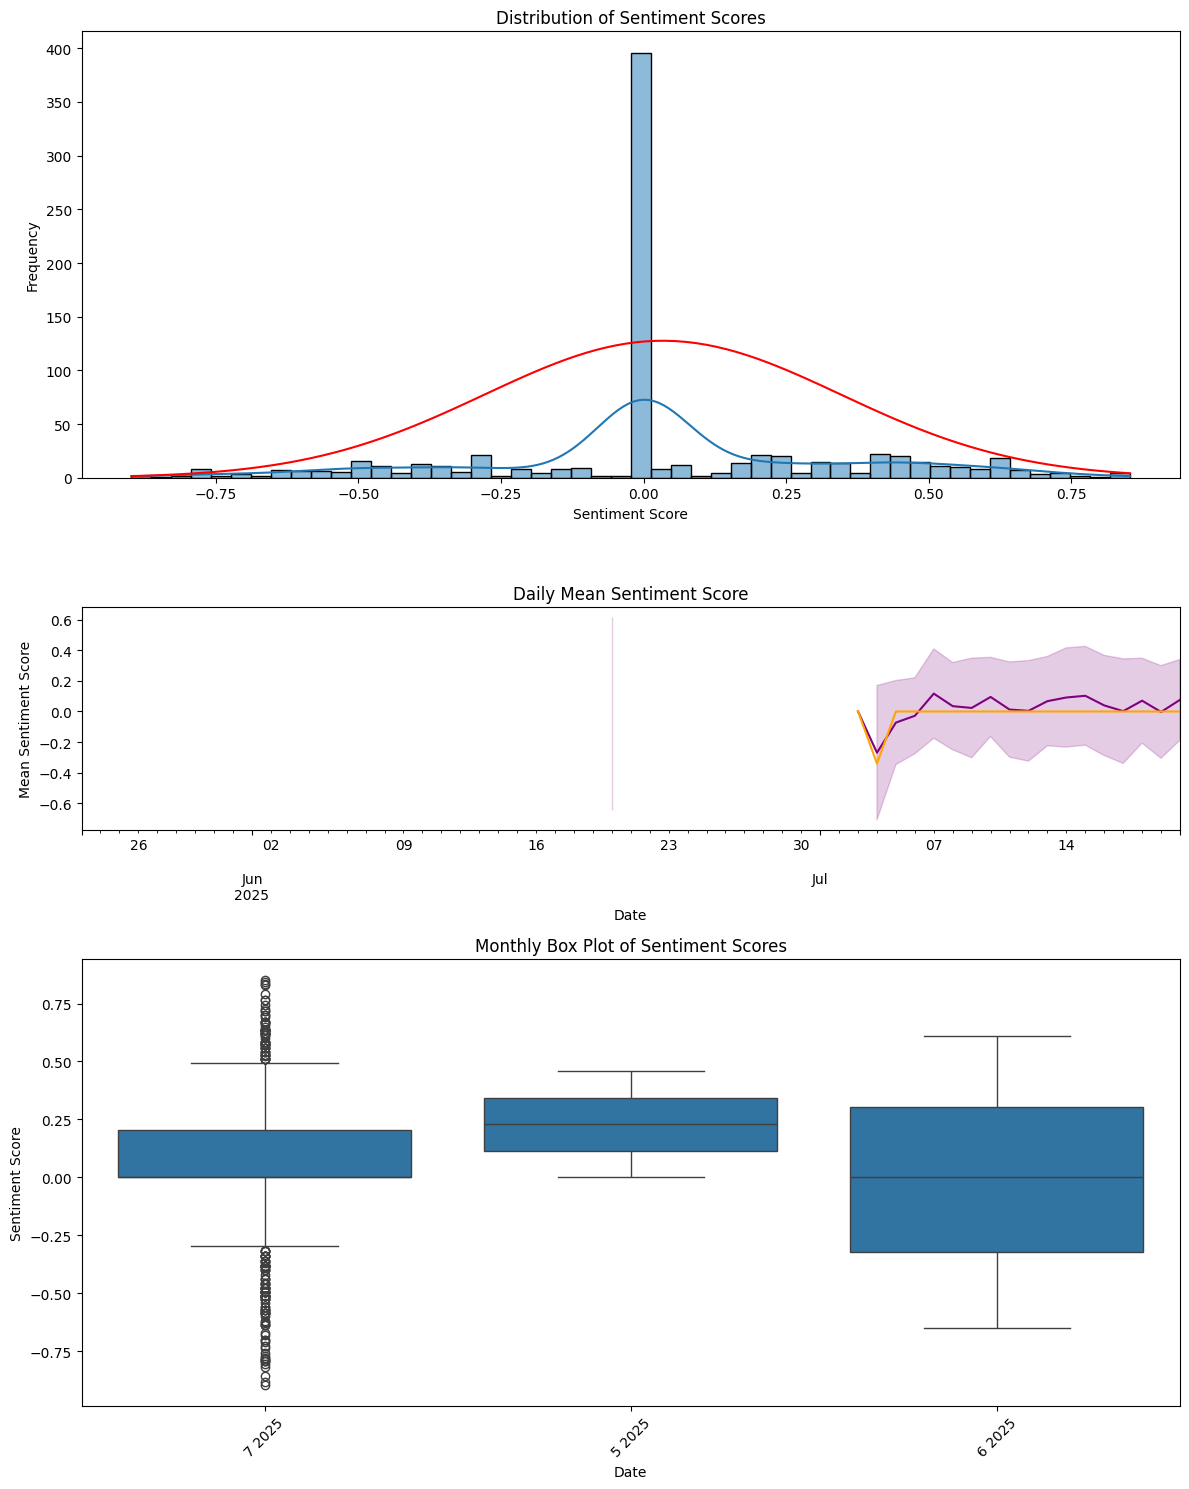

In [11]:
def plot_sentiment_distribution(df, column_name, days_ago=60):
    current_date = datetime.now()
    x_days_ago = current_date - timedelta(days=days_ago)
    df = df.loc[df.index >= x_days_ago]
    df = df.loc[df.index >= "2021-01-01"]
    # Resample by day and calculate the mean for each day
    daily_mean = df[column_name].resample('D').mean()
    daily_median = df[column_name].resample('D').median()
    daily_std = df[column_name].resample('D').std()
    df_reset = df[['num_comments', 'fetch_method', 'index', column_name]].reset_index()
    df_reset["month"] = df_reset["created_utc"].dt.month.astype(str) + " " + df_reset["created_utc"].dt.year.astype(str)


    print(df_reset.columns)
    print(df_reset.head())

    # Create a figure with two subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15),
                             gridspec_kw={'height_ratios': [2, 1, 2]},
                             sharex=False)


    mean = df[column_name].mean()
    std = df[column_name].std()
    x = np.linspace(df[column_name].min(), df[column_name].max(), 100)
    normal_dist = stats.norm.pdf(x, mean, std) * 100
    # print(f'Normal Dist: {normal_dist}')

    # Plot histogram for 'Sentiment Score' on the first subplot
    sns.histplot(df[column_name], bins=50, kde=True, ax=axes[0])
    axes[0].plot(x, normal_dist, color="red", label="Normal Distribution")
    axes[0].set_title('Distribution of Sentiment Scores')
    axes[0].set_xlabel('Sentiment Score')
    axes[0].set_ylabel('Frequency')

    # Plot daily mean sentiment scores on the second subplot
    daily_mean.plot(ax=axes[1], color='purple', label='Mean')
    axes[1].fill_between(daily_mean.index,
                        daily_mean - daily_std,
                        daily_mean + daily_std,
                        color='purple', alpha=0.2, label='±1 Std Dev')
    axes[1].plot(daily_median.index, daily_median, color='orange', label='Median')
    axes[1].set_title('Daily Mean Sentiment Score')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Mean Sentiment Score')

    # Plot box plot per day on the third subplot
    sns.boxplot(x='month', y=column_name, data=df_reset, ax=axes[2])
    axes[2].set_title('Monthly Box Plot of Sentiment Scores')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Sentiment Score')
    axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability


    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_sentiment_distribution(all_reddit_posts, 'sent_analysis_title_VADER')

##Correlation Analysis

###merging sentinell analysis with crypto data

####load crypto data

In [12]:
cryptocurrency_release_dates = {
    "Bitcoin (BTC)": "2012-01-01",
    "Ethereum (ETH)": "2015-07-30",
    "Tether (USDT)": "2014-10-06",
    "Binance Coin (BNB)": "2017-07-25",
    "USD Coin (USDC)": "2018-09-26",
    "XRP (Ripple)": "2012-01-01",
    "Solana (SOL)": "2020-03-01",
    "Cardano (ADA)": "2017-09-29",
    "Dogecoin (DOGE)": "2013-12-06",
    "Toncoin (TON)": "2021-08-01",
    "Polkadot (DOT)": "2020-05-26",
    "Litecoin (LTC)": "2012-01-01",
    "Chainlink (LINK)": "2017-09-19",
    "Uniswap (UNI)": "2020-09-16",
    "Bitcoin Cash (BCH)": "2017-08-01",
    "Stellar (XLM)": "2014-07-31",
    "VeChain (VET)": "2018-08-01",
    "TRON (TRX)": "2017-09-13",
    "Filecoin (FIL)": "2020-10-15",
    "Aave (AAVE)": "2020-10-01"
}

In [13]:
folder_path_crypto = '/drive/My Drive/Colab Notebooks/Crypto Project/Data/cryptocompare'

coin_dict = {}
for coin, release_date in cryptocurrency_release_dates.items():
  coin_name = coin.split(' (')[0]
  coin_symbol = coin.split(' (')[1][:-1]
  release_date = pd.to_datetime(release_date)
  try:
    currency_df = pd.read_csv(f'{folder_path_crypto}/{coin_symbol}_file.csv', parse_dates=['time'], index_col=0, date_format='%Y-%m-%d')
    currency_df = currency_df[['time', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'close']]

  except FileNotFoundError:
    print(f"No file found for {coin_symbol}")
    continue

  coin_dict[coin_name] = currency_df

No file found for Ripple


In [14]:
print(coin_dict.keys())
print(coin_dict["Bitcoin"].head())

dict_keys(['Bitcoin', 'Ethereum', 'Tether', 'Binance Coin', 'USD Coin', 'Solana', 'Cardano', 'Dogecoin', 'Toncoin', 'Polkadot', 'Litecoin', 'Chainlink', 'Uniswap', 'Bitcoin Cash', 'Stellar', 'VeChain', 'TRON', 'Filecoin', 'Aave'])
        time   high    low   open  volumefrom   volumeto  close
0 2012-12-31  13.56  13.37  13.45    15049.79  202798.91  13.51
1 2013-01-01  13.56  13.16  13.51    28406.21  378879.35  13.30
2 2013-01-02  13.40  13.16  13.30    17966.81  239156.18  13.28
3 2013-01-03  13.46  13.25  13.28    18032.25  240845.86  13.40
4 2013-01-04  13.52  13.27  13.40    29641.92  397884.35  13.50


###correlation func

In [15]:
def merge_data_resample(coin_dict, reddit_posts,
                        coin_name='Bitcoin', merge_col='sent_analysis_text'):
    currency_df = coin_dict[coin_name].set_index('time')[['close', 'volumeto']]
    resample_posts = reddit_posts[merge_col].resample('D').mean()
    currency_df.columns = ['Value', 'Volume']
    correlation_df = currency_df.merge(
        resample_posts,
        left_index=True,
        right_index=True
    )
    correlation_df.dropna(subset=[merge_col], inplace=True)
    return correlation_df

In [16]:
def check_corr(coin_dict, resample_posts, coin_name='Bitcoin',
               sentiment_col='sent_analysis_text', show=False):

    correlation_df = merge_data_resample(coin_dict, resample_posts,
                                         coin_name=coin_name,
                                         merge_col=sentiment_col)

    # print(correlation_df.head())

    correlation_matrix = correlation_df.corr()
    # print(correlation_matrix, "\n")

    # Compute correlation and p-value
    correlation, p_value = stats.pearsonr(correlation_df["Value"], correlation_df[sentiment_col])

    if show:
      print(f"Correlation Coefficient: {correlation}")
      print(f"P-Value: {p_value}")

      # Validate correlation

    if p_value < 0.05:
        val_corr = True
    else:
        val_corr = False
    return (correlation, p_value, val_corr)


analysis = {}
for coin_name_ in coin_dict.keys():
  corr, p_val, val_cor = check_corr(coin_dict, all_reddit_posts,
            coin_name=coin_name_, sentiment_col='sent_analysis_title_VADER')
  analysis[coin_name_] = {'corr': corr, 'p_val': p_val, 'val': val_cor}

for coin_name_, val in analysis.items():
  corr = val['corr']
  p_val = val['p_val']
  val_cor = val['val']
  print(f'{coin_name_}:\n\t{corr}\n\t{p_val}\n\t{val_cor}')

Bitcoin:
	0.0588886094685883
	2.0381592731498708e-08
	True
Ethereum:
	0.010396335224203405
	0.32273443484727193
	False
Tether:
	0.025137151384096657
	0.016791116139659515
	True
Binance Coin:
	0.0009970320588266702
	0.9255818551870729
	False
USD Coin:
	0.07882007170268199
	3.761768246784447e-12
	True
Solana:
	-0.03518041136020874
	0.0030375282359113927
	True
Cardano:
	0.023076059538718118
	0.03060878779111299
	True
Dogecoin:
	0.018179119171619393
	0.08361686864209258
	False
Toncoin:
	0.027062664179166057
	0.08020854139836178
	False
Polkadot:
	0.07419757146192721
	3.9053951199834616e-10
	True
Litecoin:
	0.11407398160706313
	1.2738797117719017e-27
	True
Chainlink:
	0.07171290499234176
	1.732679249939613e-11
	True
Uniswap:
	0.08504216496257885
	7.204309621506991e-13
	True
Bitcoin Cash:
	0.0691264442445405
	8.948378681101192e-11
	True
Stellar:
	0.11615897139354854
	1.470593939195567e-28
	True
VeChain:
	0.0571407706808989
	4.861818949522026e-07
	True
TRON:
	0.042145002599547975
	7.8143289451

##Sentiment Analysis with VADER

In [ ]:
print(all_reddit_posts.columns)

Index(['index', 'title', 'score', 'author', 'url', 'text', 'num_comments',
       'subreddit', 'fetch_method', 'norm_score', 'sent_analysis_text',
       'sent_analysis_title', 'sent_analysis_title_VADER'],
      dtype='object')


In [17]:
df = all_reddit_posts[['title']]
# Example DataFrame
# data = {"text": ["I love programming. Python is amazing!", "I hate bugs, but debugging can be fun."]}
# df = pd.DataFrame(data)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Preprocessing function
def preprocess_and_analyze(text):
    # Tokenize and clean text
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words("english"))
    clean_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Count word frequencies
    word_freq = Counter(clean_tokens)

    # Get sentiment for each word
    word_sentiments = {word: sia.polarity_scores(word)["compound"] for word in clean_tokens}

    return word_freq, word_sentiments

# Apply the function
word_counts = Counter()
word_sentiments = {}

for text in df["title"]:
    wc, ws = preprocess_and_analyze(text)
    word_counts.update(wc)
    word_sentiments.update(ws)

# Combine results into a DataFrame
result_df = pd.DataFrame({
    "word": list(word_counts.keys()),
    "frequency": list(word_counts.values()),
    "sentiment": [word_sentiments[word] for word in word_counts.keys()]
})

# Sort by frequency
result_df = result_df.sort_values(by="frequency", ascending=False).reset_index(drop=True)



display(result_df)


,word,frequency,sentiment
0,crypto,1233,0.0
1,bitcoin,754,0.0
2,market,250,0.0
3,ethereum,244,0.0
4,btc,224,0.0
...,...,...,...
7200,gruenberg,1,0.0
7201,chokepoint,1,0.0
7202,architect,1,0.0
7203,mysteriously,1,0.0


In [18]:
df = all_reddit_posts[['title']]
df.columns = ['post']

sia = SentimentIntensityAnalyzer()
# List of cryptocurrencies to analyze
cryptos = ["Bitcoin", "Solana"]

# Function to analyze sentiment for specific cryptocurrencies
def analyze_crypto_sentiment(posts, crypto_list):
    results = []
    for crypto in crypto_list:
        for post in posts:
            if crypto.lower() in post.lower():  # Check if crypto is mentioned
                sentiment = sia.polarity_scores(post)["compound"]  # Analyze sentiment
                results.append({"crypto": crypto, "post": post, "sentiment": sentiment})
    return pd.DataFrame(results)

# Analyze sentiment for mentions of cryptocurrencies
crypto_sentiment_df = analyze_crypto_sentiment(df["post"], cryptos)

# Aggregate results (optional)
summary = crypto_sentiment_df.groupby("crypto")["sentiment"].agg(["mean", "count"]).reset_index()

# Display results
print("Detailed Analysis:")
print(crypto_sentiment_df)
print("\nSummary:")
print(summary)

Detailed Analysis:
      crypto                                               post  sentiment
0    Bitcoin  Billionaire Mike Novogratz Says Bitcoin Could ...     0.0000
1    Bitcoin  Bitcoin Address Wakes Up After Lying Low for O...    -0.3818
2    Bitcoin  Bitcoin has broken back to the green line in t...    -0.4767
3    Bitcoin  Bitcoin Nears $98,000, Just 2% Away From Six F...     0.0000
4    Bitcoin  ETH-to-BTC price ratio drops to lowest since M...    -0.3818
..       ...                                                ...        ...
827   Solana  Solana Tops All Chains in Network Revenue for ...     0.6369
828   Solana  SEC Sets July Deadline for Solana (SOL) ETF Re...     0.4767
829   Solana  Solana ETF pulls in a record $12 million on de...     0.0000
830   Solana  Solana bot scam on GitHub steals crypto from u...    -0.7906
831   Solana  Solana celebrates a year without network failu...     0.7335

[832 rows x 3 columns]

Summary:
    crypto      mean  count
0  Bitcoin  0.05136

In [19]:
corped_df = crypto_sentiment_df.loc[crypto_sentiment_df['sentiment'] != 0.0]
rand_sample = corped_df.sample(n=20, random_state=42)

sampled_df = corped_df.groupby("crypto", group_keys=False).apply(lambda group: group.sample(n=5, random_state=42))


for row in sampled_df.iterrows():
  crypto = row[1].iloc[0]
  post = row[1].iloc[1]
  sentiment = row[1].iloc[2]
  if sentiment == 0:
    continue
  print(f"Currency: {crypto}\n\tPost: {post}\n\tSentiment: {sentiment}")

Currency: Bitcoin
	Post: Wall Street Titans Went from Calling Bitcoin a Scam to Owning and Endorsing It
	Sentiment: -0.5719
Currency: Bitcoin
	Post: Bitcoin Mining Giant Riot Platforms Adds More Than $510,000,000 Worth of BTC to Corporate Treasury - The Daily Hodl
	Sentiment: -0.1621
Currency: Bitcoin
	Post: Tether Prepares for Demand Surge With $1B USDT Mint After Bitcoin ATH
	Sentiment: -0.128
Currency: Bitcoin
	Post: Increased demand and heightened volatility signal further upside for Bitcoin
	Sentiment: 0.1531
Currency: Bitcoin
	Post: 13 years ago today, a $110 million Bitcoin mistake ✨
	Sentiment: -0.34
Currency: Solana
	Post: I'm still using Trojan to trade on solana, anything better?
	Sentiment: 0.4404
Currency: Solana
	Post: Ethereum's Growing Solana Problem Highlighted by Dev's Defection
	Sentiment: -0.5267
Currency: Solana
	Post: 2 years ago: a “contrarian thread” that Solana would still make it after the Alameda/FTX collapse. Interesting looking back
	Sentiment: -0.128
Curre

/tmp/ipython-input-19-1434286615.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = corped_df.groupby("crypto", group_keys=False).apply(lambda group: group.sample(n=5, random_state=42))
